In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [7]:
import os

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/Users/cremones/EPFL/PCML/pcml-project1/data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH, sub_sample=True)

In [3]:
N_FEATURES=tX.shape[1]
N_SAMPLES=tX.shape[0]

print( "loaded training data: %d samples and %d features\n"%(N_SAMPLES, N_FEATURES) )

print("**************************************")
print("first feature vector:")
print(tX[0,:])
print("**************************************")

loaded training data: 5000 samples and 30 features

**************************************
first feature vector:
[  1.38470000e+02   5.16550000e+01   9.78270000e+01   2.79800000e+01
   9.10000000e-01   1.24711000e+02   2.66600000e+00   3.06400000e+00
   4.19280000e+01   1.97760000e+02   1.58200000e+00   1.39600000e+00
   2.00000000e-01   3.26380000e+01   1.01700000e+00   3.81000000e-01
   5.16260000e+01   2.27300000e+00  -2.41400000e+00   1.68240000e+01
  -2.77000000e-01   2.58733000e+02   2.00000000e+00   6.74350000e+01
   2.15000000e+00   4.44000000e-01   4.60620000e+01   1.24000000e+00
  -2.47500000e+00   1.13497000e+02]
**************************************


In [29]:
feature_names=('DER_mass_MMC' , 'DER_mass_transverse_met_lep' , 'DER_mass_vis' , 'DER_pt_h' , 'DER_deltaeta_jet_jet' , 'DER_mass_jet_jet' , 'DER_prodeta_jet_jet' , 'DER_deltar_tau_lep' , 'DER_pt_tot' , 'DER_sum_pt' , 'DER_pt_ratio_lep_tau' , 'DER_met_phi_centrality' , 'DER_lep_eta_centrality' , 'PRI_tau_pt' , 'PRI_tau_eta' , 'PRI_tau_phi' , 'PRI_lep_pt' , 'PRI_lep_eta' , 'PRI_lep_phi' , 'PRI_met' , 'PRI_met_phi' , 'PRI_met_sumet' , 'PRI_jet_num' , 'PRI_jet_leading_pt' , 'PRI_jet_leading_eta' , 'PRI_jet_leading_phi' , 'PRI_jet_subleading_pt' , 'PRI_jet_subleading_eta' , 'PRI_jet_subleading_phi' , 'PRI_jet_all_pt')

In [49]:
primitive_features_indices=[index for index,name in enumerate(feature_names) if name[0:3]=='PRI']
N_PRI_FEAT=len(primitive_features_indices)
print("detected %d primitive features"%(N_PRI_FEAT))
#print(primitive_features_indices)
#for index in primitive_features_indices:
#    print(feature_names[index])

detected 17 primitive features


In [70]:
PRI_tX = []
for index in primitive_features_indices:
    PRI_tX.append(tX[:,index])
PRI_tX = np.array(PRI_tX).T.reshape( (N_SAMPLES,N_PRI_FEAT) )
#print(PRI_tX.shape)
#print(tX[0:3,primitive_features_indices[0]])
#print(tX[0:3,primitive_features_indices[1]])
#print(PRI_tX[0:3,:])

In [5]:
y_colors = np.array(['b']*N_SAMPLES)
y_colors[y==-1] = 'r'
# If I understood correctly, -1 are bosons, i.e. boson events will be colored in red

In [ ]:
C=np.corrcoef(tX,rowvar=False)
plt.figure(figsize=(8,8))
plt.imshow(C,interpolation='nearest',cmap='hot')
plt.colorbar()
plt.show()

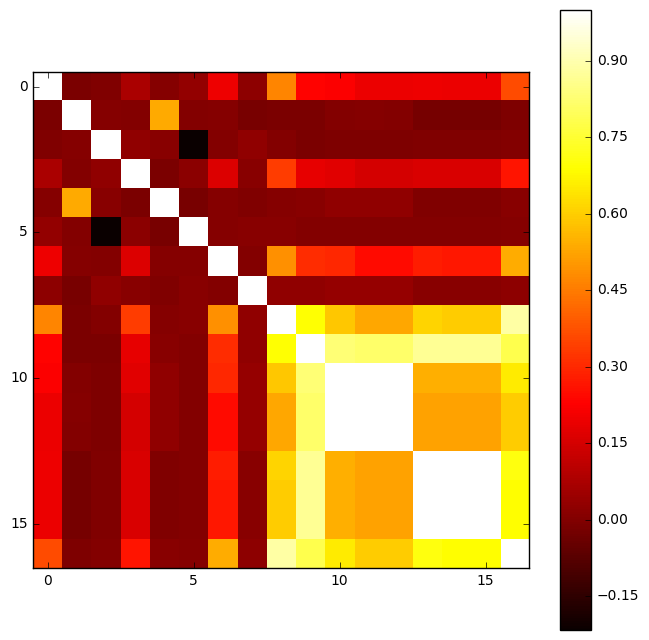

In [71]:
C=np.corrcoef(PRI_tX,rowvar=False)
plt.figure(figsize=(8,8))
plt.imshow(C,interpolation='nearest',cmap='hot')
plt.colorbar()
plt.show()

In [ ]:
first_var=4
second_var=6
f = plt.figure(figsize=(8,8))
plt.scatter(tX[:,first_var], tX[:,second_var])
plt.ylabel(feature_names[second_var])
plt.xlabel(feature_names[first_var])
plt.show()

In [ ]:
first_var=4
second_var=12
f = plt.figure(figsize=(8,8))
plt.scatter(tX[:,first_var], tX[:,second_var])
plt.ylabel(feature_names[second_var])
plt.xlabel(feature_names[first_var])
plt.show()

In [ ]:
first_var=4
second_var=26
f = plt.figure(figsize=(8,8))
plt.scatter(tX[:,first_var], tX[:,second_var])
plt.ylabel(feature_names[second_var])
plt.xlabel(feature_names[first_var])
plt.show()

In [ ]:
first_var=4
second_var=27
f = plt.figure(figsize=(8,8))
plt.scatter(tX[:,first_var], tX[:,second_var])
plt.ylabel(feature_names[second_var])
plt.xlabel(feature_names[first_var])
plt.show()

In [ ]:
first_var=4
second_var=28
f = plt.figure(figsize=(8,8))
plt.scatter(tX[:,first_var], tX[:,second_var])
plt.ylabel(feature_names[second_var])
plt.xlabel(feature_names[first_var])
plt.show()

In [ ]:
first_var=23
second_var=24
f = plt.figure(figsize=(8,8))
plt.scatter(tX[:,first_var], tX[:,second_var])
plt.ylabel(feature_names[second_var])
plt.xlabel(feature_names[first_var])
plt.show()

In [ ]:
first_var=24
second_var=25
f = plt.figure(figsize=(8,8))
plt.scatter(tX[:,first_var], tX[:,second_var])
plt.ylabel(feature_names[second_var])
plt.xlabel(feature_names[first_var])
plt.show()

##### Input Size Reduction

In [6]:
tX_old = tX
print (tX.shape)
tX=np.delete(tX,[6, 12, 27, 28, 25],1)
print (tX.shape)

(250000, 30)
(250000, 25)


In [7]:
print(len(feature_names))
feature_names=np.delete( feature_names, [6, 12, 27, 28, 25] )
print(len(feature_names))

30
25


In [8]:
N_FEATURES=tX.shape[1]
N_SAMPLES=tX.shape[0]

print( "new training dataset: %d samples and %d features\n"%(N_SAMPLES, N_FEATURES) )

new training dataset: 250000 samples and 25 features



In [ ]:
C=np.corrcoef(tX,rowvar=False)
plt.figure(figsize=(8,8))
plt.imshow(C,interpolation='nearest',cmap='hot')
plt.colorbar()
plt.show()

plotting a 5 x 6 matrix


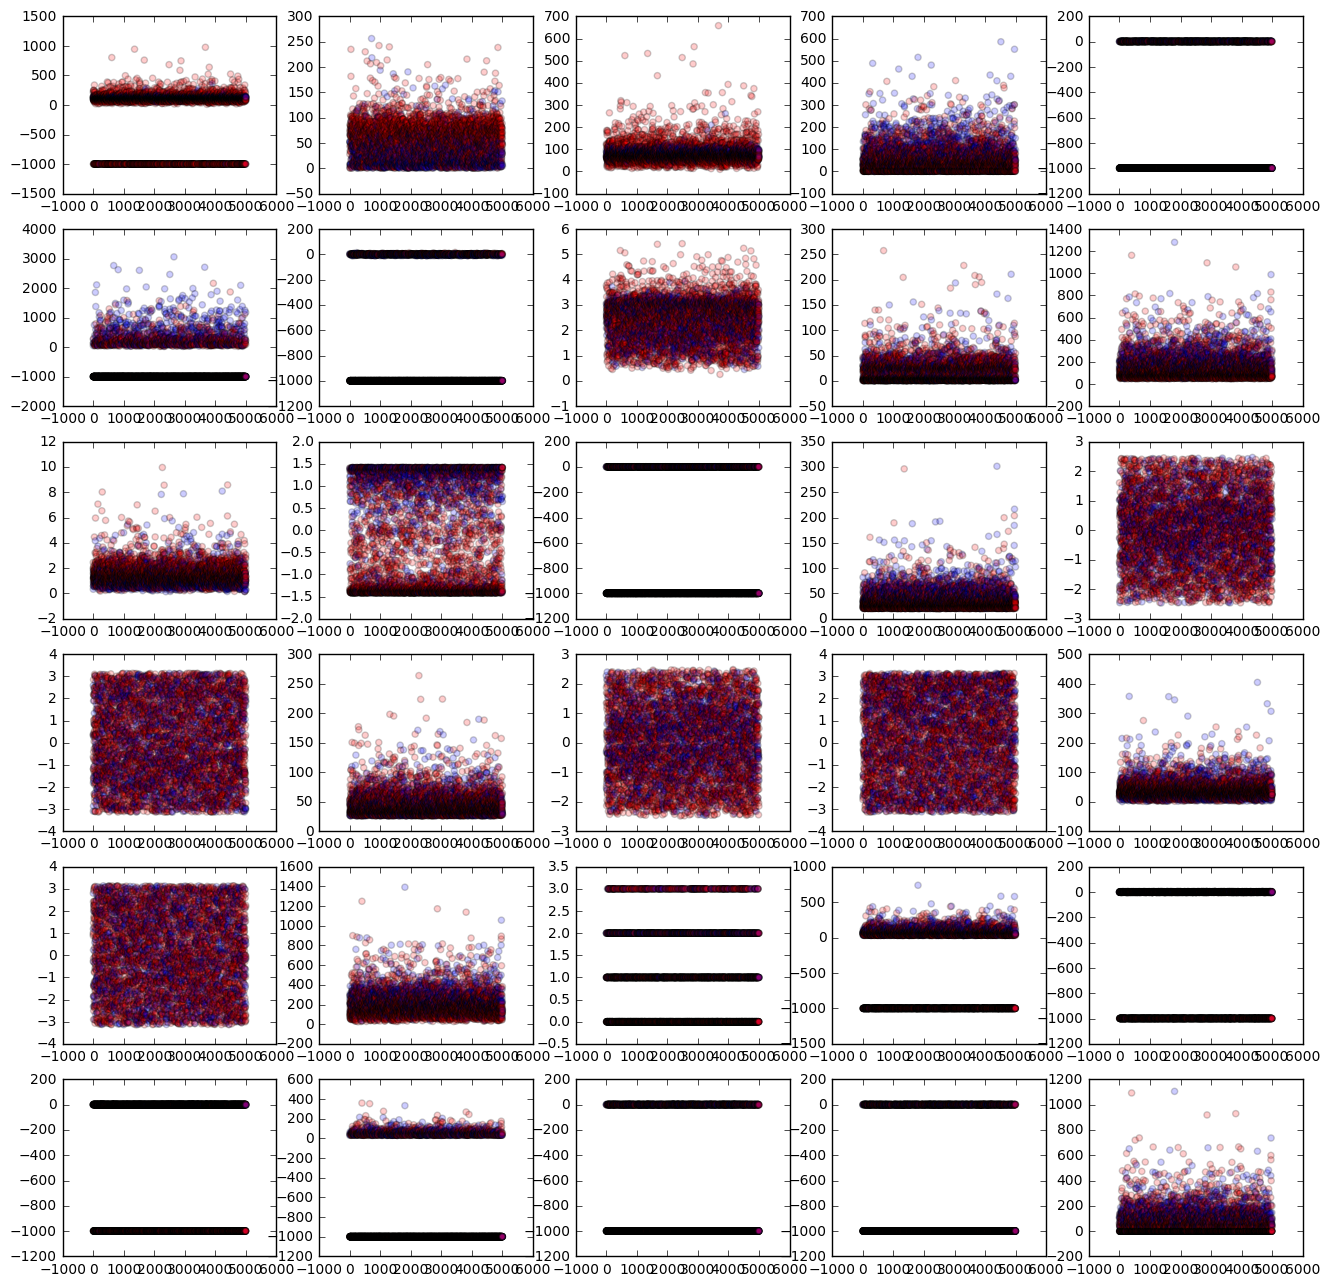

In [14]:
n_cols_plots=5
n_rows_plots=int(N_FEATURES/n_cols_plots)
print ( "plotting a %d x %d matrix" % (n_cols_plots, n_rows_plots))
#n_rows_plots=1
#f, ax_array = plt.subplots(n_rows_plots, n_cols_plots, sharex='col', sharey='row')
f, ax_array = plt.subplots(n_rows_plots, n_cols_plots, figsize=(16, 16 ))

for row in range(n_rows_plots):
    axes = ax_array[row]
    for col in range(n_cols_plots):
        #ax = ax_array[row*n_cols_plots + col]
        ax = axes[col]
        data_to_plot=tX[:,row*n_cols_plots + col]
        ax.scatter(range(N_SAMPLES), data_to_plot, c=y_colors,alpha=0.2)
        
        
figpath=os.path.join( os.getcwd(), "..", "figures", "scatterplots.pdf")

plt.savefig(figpath)
#plt.show()

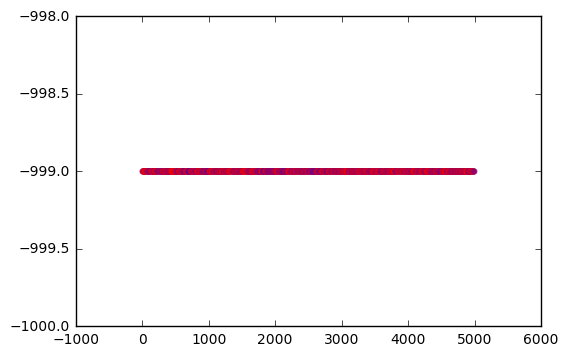

In [21]:
plt.figure()
plt.scatter(range(N_SAMPLES), tX[:,4], c=y_colors,alpha=0.2, lw=0)
axes=plt.gca()
axes.set_ylim([-1000,-998])
plt.show()

In [11]:
import itertools
def scatterplot_matrix(data, names,  **kwargs):
    """Plots a scatterplot matrix of subplots.  Each column of "data" is plotted
    against other columns, resulting in a ncols by ncols grid of subplots with the
    diagonal subplots labeled with "names".  Additional keyword arguments are
    passed on to matplotlib's "plot" command. Returns the matplotlib figure
    object containg the subplot grid.
    From http://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib
    """
    data = data.T # originally the function worked on rows
    numvars, numdata = data.shape
    fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(33.1, 46.7))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')

    # Plot the data.
    for i, j in zip(*np.triu_indices_from(axes, k=1)):
        for x, y in [(i,j), (j,i)]:
            axes[x,y].scatter(data[x], data[y], **kwargs)

    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
        axes[j,i].xaxis.set_visible(True)
        axes[i,j].yaxis.set_visible(True)

    return fig

In [11]:
plt.figure()
f = scatterplot_matrix(tX, feature_names, c=y_colors, alpha=0.2)
plt.savefig('/Users/cremones/EPFL/PCML/pcml-project1/figures/scatterplot-matrix-sub.pdf')

KeyboardInterrupt: 

KeyboardInterrupt: 

## Do your thing crazy machine learning thing here :) ...

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)